# **Projet Data Mining**

L’objectif de ce projet est d’analyser les commentaires des utilisateurs (variable "review_comment_message")
en langue portugaise afin de comprendre les différents niveaux de satisfaction client. Nous avons classifié la
satisfaction en quatre catégories : "très satisfait", "satisfait", "mécontent", et "insatisfait". Ce rapport pré-
sente les différentes étapes de traitement des données, la segmentation des commentaires et la mise en place
d’un modèle de deep learning pour prédire la satisfaction des clients.**

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
sns.set()

## Importation des données

In [4]:
def read_csv(path):
    data = pd.read_csv(path, sep=",", encoding="utf-8", index_col="uniq_id")
    return data

In [5]:
data = pd.read_csv("olist_order_reviews_dataset.csv") 

In [6]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\ROMUALD
[nltk_data]     DJAHOUA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\ROMUALD
[nltk_data]     DJAHOUA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
data.dropna(subset=["review_comment_message"], inplace=True)

In [ ]:
data["review_comment_message"].describe

In [11]:
data.shape

(40977, 7)

In [12]:
# data["review_comment_message"] = data["review_comment_message"].fillna("")


In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def clean_and_tokenize_text(data, column_name):
    stop_words = stopwords.words("portuguese")  
    data[column_name] = data[column_name].apply(lambda x: " ".join(word.lower() for word in x.split()))  
    data[column_name] = data[column_name].str.replace(r'[^\w\s]', '', regex=True)  
    data[column_name] = data[column_name].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
    data["tokenized_" + column_name] = data[column_name].apply(word_tokenize)  
    return data


In [14]:

nltk.download('punkt_tab')
data = clean_and_tokenize_text(data, "review_comment_message")


[nltk_data] Downloading package punkt_tab to C:\Users\ROMUALD
[nltk_data]     DJAHOUA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [15]:
data["review_comment_message"].head()

3                     recebi bem antes prazo estipulado
4     parabéns lojas lannister adorei comprar intern...
9     aparelho eficiente site marca aparelho impress...
12                      pouco travandopelo valor ta boa
15    vendedor confiável produto ok entrega antes prazo
Name: review_comment_message, dtype: object

In [16]:
data.shape

(40977, 8)

In [17]:
data.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'tokenized_review_comment_message'],
      dtype='object')

In [18]:
data.shape

(40977, 8)

In [19]:
data["review_comment_message"].head()

3                     recebi bem antes prazo estipulado
4     parabéns lojas lannister adorei comprar intern...
9     aparelho eficiente site marca aparelho impress...
12                      pouco travandopelo valor ta boa
15    vendedor confiável produto ok entrega antes prazo
Name: review_comment_message, dtype: object

In [20]:
data.isna().sum()

review_id                               0
order_id                                0
review_score                            0
review_comment_title                31138
review_comment_message                  0
review_creation_date                    0
review_answer_timestamp                 0
tokenized_review_comment_message        0
dtype: int64

# 1. Ctégories : target

## Convertion des variables

In [21]:
comments = data['review_comment_message'].fillna("")

review_scores = data['review_score']

def categorize_review(score):
    if score <= 1.5:
        return "mécontent"
    elif 1.5 < score < 2.5:
        return "insatisfait"
    elif 2.5 <= score <= 3.5:
        return "satisfait"
    else:
        return "très satisfait"

data['target'] = review_scores.apply(categorize_review)

In [22]:
data["target"].value_counts()

target
très satisfait    26530
mécontent          8745
satisfait          3557
insatisfait        2145
Name: count, dtype: int64

## Histogramme réprésentant les target

In [23]:
graph1 = pd.DataFrame({"target": data["target"].value_counts().index, "values":data["target"].value_counts().values})

C:\Users\ROMUALD DJAHOUA\AppData\Local\Temp\ipykernel_27960\3252457551.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="target", x="values", data=graph1, palette="Set2")


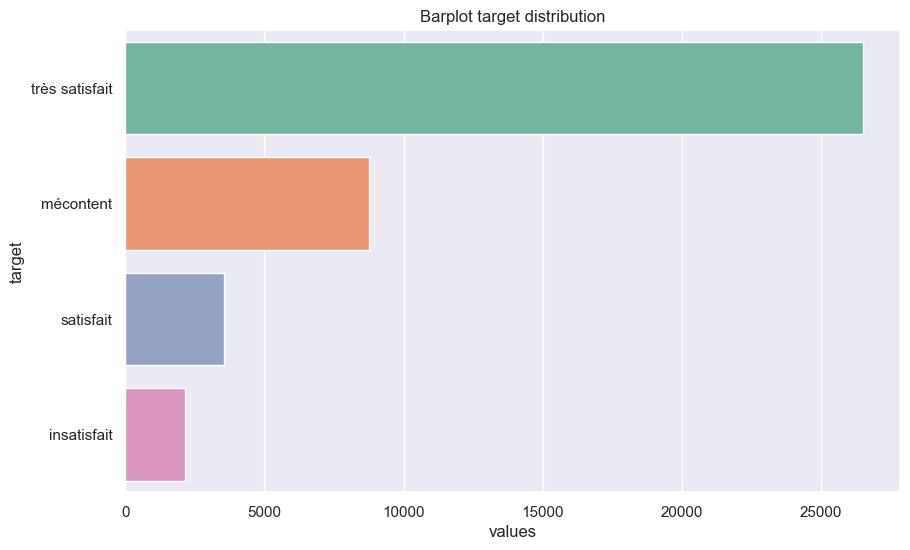

In [24]:
            plt.figure(figsize=(10,6))
sns.barplot(y="target", x="values", data=graph1, palette="Set2")
plt.title("Barplot target distribution")
plt.show()

Le graphique illustre une répartition statistiquement déséquilibrée des observations entre les différentes
catégories de satisfaction. La catégorie "Très satisfait" domine largement, représentant la majorité des don-
nées, tandis que "Mécontent" suit avec un nombre nettement inférieur. Les catégories "Satisfait" et "Insatis-
fait" sont les moins fréquentes, avec des proportions significativement plus faibles

# 2. Traitement de langage naturel

In [25]:
data["review_comment_message"] = data["review_comment_message"].fillna("").apply(
    lambda x: " ".join(x.lower() for x in x.split())
)


In [26]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,tokenized_review_comment_message,target
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,recebi bem antes prazo estipulado,2017-04-21 00:00:00,2017-04-21 22:02:06,"[recebi, bem, antes, prazo, estipulado]",très satisfait
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,parabéns lojas lannister adorei comprar intern...,2018-03-01 00:00:00,2018-03-02 10:26:53,"[parabéns, lojas, lannister, adorei, comprar, ...",très satisfait
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente site marca aparelho impress...,2018-05-22 00:00:00,2018-05-23 16:45:47,"[aparelho, eficiente, site, marca, aparelho, i...",très satisfait
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,pouco travandopelo valor ta boa,2018-02-16 00:00:00,2018-02-20 10:52:22,"[pouco, travandopelo, valor, ta, boa]",très satisfait
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,vendedor confiável produto ok entrega antes prazo,2018-05-23 00:00:00,2018-05-24 03:00:01,"[vendedor, confiável, produto, ok, entrega, an...",très satisfait


In [27]:
data["review_comment_message"] = data["review_comment_message"].str.replace('[^\w\s]','')

In [28]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,tokenized_review_comment_message,target
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,recebi bem antes prazo estipulado,2017-04-21 00:00:00,2017-04-21 22:02:06,"[recebi, bem, antes, prazo, estipulado]",très satisfait
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,parabéns lojas lannister adorei comprar intern...,2018-03-01 00:00:00,2018-03-02 10:26:53,"[parabéns, lojas, lannister, adorei, comprar, ...",très satisfait
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente site marca aparelho impress...,2018-05-22 00:00:00,2018-05-23 16:45:47,"[aparelho, eficiente, site, marca, aparelho, i...",très satisfait
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,pouco travandopelo valor ta boa,2018-02-16 00:00:00,2018-02-20 10:52:22,"[pouco, travandopelo, valor, ta, boa]",très satisfait
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,vendedor confiável produto ok entrega antes prazo,2018-05-23 00:00:00,2018-05-24 03:00:01,"[vendedor, confiável, produto, ok, entrega, an...",très satisfait


In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\ROMUALD
[nltk_data]     DJAHOUA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Chargement des stopwords en portugais

In [30]:

stop = stopwords.words('portuguese')


data["review_comment_message"] = data["review_comment_message"].apply(
    lambda x: " ".join(word for word in x.split() if word not in stop)
)

data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,tokenized_review_comment_message,target
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,recebi bem antes prazo estipulado,2017-04-21 00:00:00,2017-04-21 22:02:06,"[recebi, bem, antes, prazo, estipulado]",très satisfait
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,parabéns lojas lannister adorei comprar intern...,2018-03-01 00:00:00,2018-03-02 10:26:53,"[parabéns, lojas, lannister, adorei, comprar, ...",très satisfait
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente site marca aparelho impress...,2018-05-22 00:00:00,2018-05-23 16:45:47,"[aparelho, eficiente, site, marca, aparelho, i...",très satisfait
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,pouco travandopelo valor ta boa,2018-02-16 00:00:00,2018-02-20 10:52:22,"[pouco, travandopelo, valor, ta, boa]",très satisfait
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,vendedor confiável produto ok entrega antes prazo,2018-05-23 00:00:00,2018-05-24 03:00:01,"[vendedor, confiável, produto, ok, entrega, an...",très satisfait


In [31]:
from nltk.tokenize import word_tokenize



In [32]:
data['token_review_comment_message'] = data['review_comment_message'].apply(word_tokenize)

In [33]:

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn import preprocessing
import time

seed = 22


### Création des fonction pour la segmentation

In [34]:
def PCA_fct(X, n_components=0.95):

    # PCA = ACP

    print("Dimensions dataset avant réduction PCA : ", X.shape)
    pca = decomposition.PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    print("Dimensions dataset après réduction PCA : ", X_pca.shape)

    return X_pca


In [35]:
def TSVD_fct(X, n_components=0.95):
        
        
 # PCA = ACP

    print("Dimensions dataset avant réduction PCA : ", X.shape)

    for n in range(100, X.shape[1], 10):
        pca = decomposition.TruncatedSVD(n_components=n, random_state=seed)
        X_pca = pca.fit_transform(X)
        if pca.explained_variance_ratio_.sum() >= n_components : break
    print("Dimensions dataset après réduction PCA : ", X_pca.shape)

    return X_pca


In [36]:


def ARI_fct(X_pca, true_labels, perplexity=30, learning_rate=100, n_iter=2000):

    time1 = time.time()

    tsne = manifold.TSNE(n_components=2,
                        perplexity=perplexity,
                        n_iter=n_iter,
                        init='random',
                        learning_rate=learning_rate,
                        random_state=seed)
    X_tsne = tsne.fit_transform(X_pca)

    # Détermination des clusters à partir des données après tsne

    cls = cluster.KMeans(n_clusters=5, n_init=100, random_state=seed)
    cls.fit(X_tsne)

    #Calcul du score ARI

    model_labels = cls.labels_
    ARI = np.round(metrics.adjusted_rand_score(true_labels, model_labels),4)

    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "\nTime :", time2)

    return ARI, X_tsne, model_labels



In [37]:
def TSNE_visu_fct(X_tsne, true_labels, model_labels) :
    fig = plt.figure(figsize=(20,10))
    
    le = preprocessing.LabelEncoder()
    true_labels_num = le.fit_transform(true_labels)
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],
                        X_tsne[:,1],
                        c = true_labels_num,
                        cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0],
             labels = set(true_labels),
             loc = 'best',
             title = 'Categories')
    plt.title('Représentation des articles par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],
                        X_tsne[:,1],
                        c = model_labels,
                        cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0],
             labels = set(model_labels),
             loc = 'best',
             title = 'Categories')
    plt.title('Représentation des articles par clusters')


In [38]:
true_labels = data.target.tolist()

In [39]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

## Approche de type  bag of words 


### Représentation graphique

Dimensions dataset avant réduction PCA :  (5000, 5317)


C:\Users\ROMUALD DJAHOUA\AppData\Local\Temp\ipykernel_27960\719998909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['joined_tokens'] = sampled_data['tokenized_review_comment_message'].apply(lambda x: ' '.join(x))


Dimensions dataset après réduction PCA :  (5000, 1340)


c:\Users\ROMUALD DJAHOUA\OneDrive\Bureau\Projet - Dat Minig\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0668 
Time : 35.0


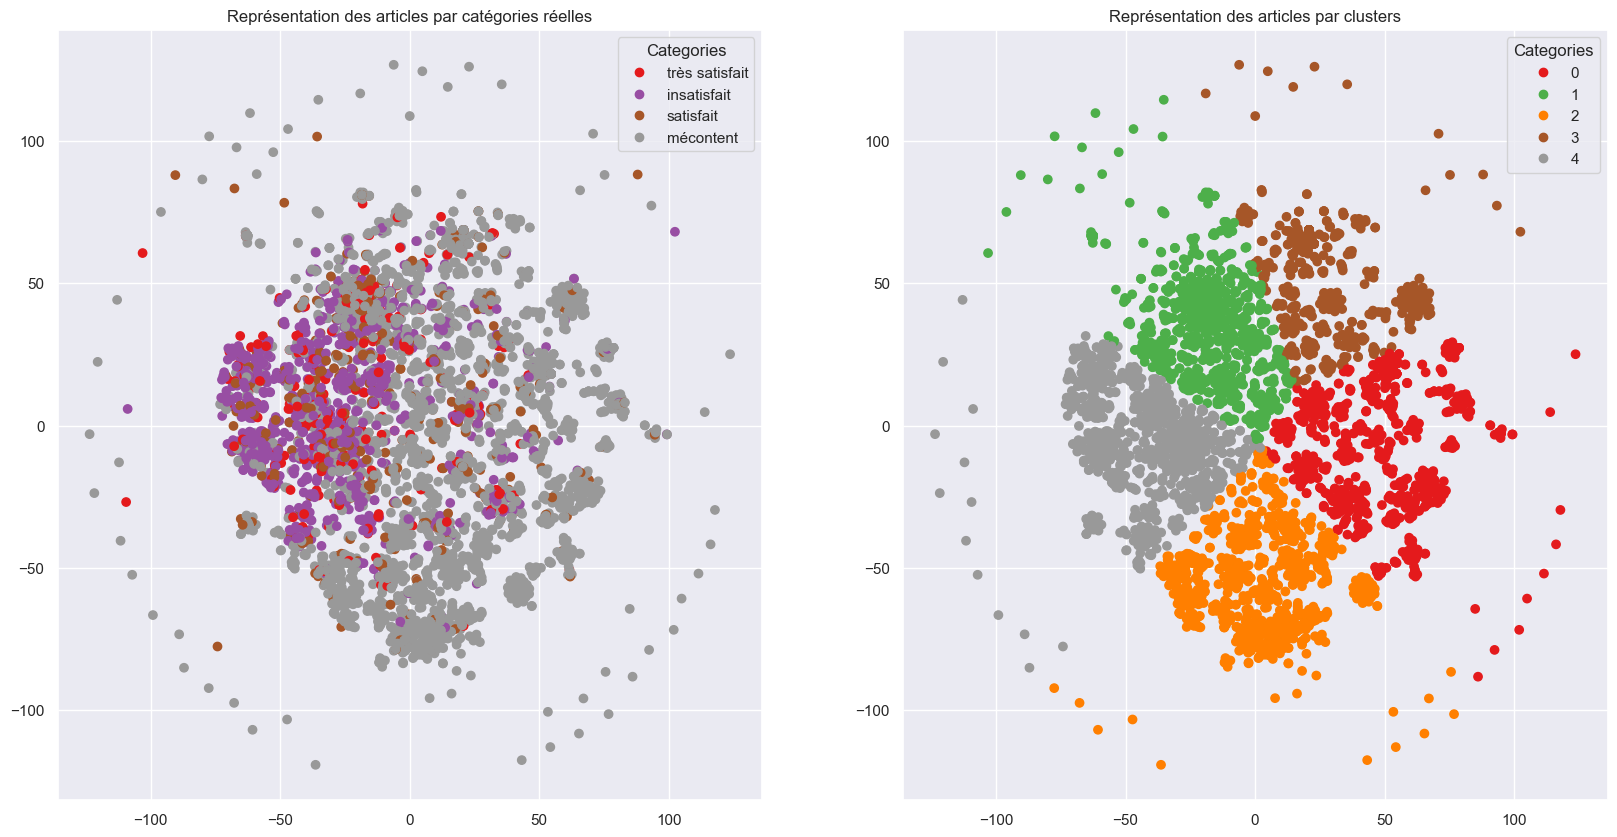

In [40]:
from sklearn.feature_extraction.text import CountVectorizer


sampled_data = data.iloc[:5000]


sampled_data['joined_tokens'] = sampled_data['tokenized_review_comment_message'].apply(lambda x: ' '.join(x))

cv = CountVectorizer()



X = cv.fit_transform(sampled_data["joined_tokens"])

X_pca = TSVD_fct(X)

ARI, X_tsne, model_labels = ARI_fct(X_pca,
                                    sampled_data["target"],
                                    perplexity=10,
                                    learning_rate=50)
TSNE_visu_fct(X_tsne, sampled_data["target"], model_labels)


ces graphiques comparent les catégories réelles (gauche) et les clusters générés automatiquement (droite).
À gauche, les points des différentes catégories sont mélangés, montrant une faible séparation visuelle entre
elles. À droite, les clusters sont mieux définis et distincts, montrant que l’algorithme de regroupement a
trouvé des groupes clairs. Cependant, il peut y avoir des désaccords entre les clusters et les catégories
réelles, notamment dans les zones de mélange. Ces visualisations suggèrent que les données présentent des
similarités importantes entre certaines catégories, rendant la classification plus complexe.

# Modèle de deep learling 

In [41]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV


##

In [45]:

y = data['target'].values  


sample_size = min(len(X_pca), len(y))

X_pca = X_pca[:sample_size]
y = y[:sample_size]

print("Shape de X_pca :", X_pca.shape)
print("Shape de y :", len(y))


Shape de X_pca : (5000, 1340)
Shape de y : 5000


In [53]:
print("Shape de X_pca :", X_pca.shape)
print("Shape de y :", len(y))


Shape de X_pca : (5000, 1340)
Shape de y : 5000


In [47]:
sample_size = min(len(X_pca), len(y))


X_pca = X_pca[:sample_size]
y = y[:sample_size]


print("Dimensions de X_pca :", X_pca.shape)
print("Dimensions de y :", len(y))


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=25)

print("Taille de x_train :", x_train.shape)
print("Taille de y_train :", len(y_train))
print("Taille de x_test :", x_test.shape)
print("Taille de y_test :", len(y_test))


Dimensions de X_pca : (5000, 1340)
Dimensions de y : 5000
Taille de x_train : (4000, 1340)
Taille de y_train : 4000
Taille de x_test : (1000, 1340)
Taille de y_test : 1000


In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


LE = LabelEncoder()
y = LE.fit_transform(data['target']) 


sample_size = min(len(X_pca), len(y))  
X_pca = X_pca[:sample_size]
y = y[:sample_size]


print("Dimensions de X_pca :", X_pca.shape)
print("Taille de y :", len(y))


print('Valeurs transformées pour les 5 premières lignes :', y[:5])
print('Valeurs originales pour les 5 premières lignes :', LE.inverse_transform(y[:5]))


x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=25)

print("Dimensions de x_train :", x_train.shape)
print("Dimensions de y_train :", len(y_train))
print("Dimensions de x_test :", x_test.shape)
print("Dimensions de y_test :", len(y_test))


Dimensions de X_pca : (5000, 1340)
Taille de y : 5000
Valeurs transformées pour les 5 premières lignes : [3 3 3 3 3]
Valeurs originales pour les 5 premières lignes : ['très satisfait' 'très satisfait' 'très satisfait' 'très satisfait'
 'très satisfait']
Dimensions de x_train : (4000, 1340)
Dimensions de y_train : 4000
Dimensions de x_test : (1000, 1340)
Dimensions de y_test : 1000


In [49]:
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(480,)))
network.add(layers.Dense(4, activation='softmax'))

network.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

from keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

c:\Users\ROMUALD DJAHOUA\OneDrive\Bureau\Projet - Dat Minig\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
from keras import models, layers
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)


print("Dimensions de x_train_scaled :", x_train_scaled.shape)
print("Dimensions de train_labels :", train_labels.shape)


network = models.Sequential()

network.add(layers.Dense(512, activation='relu', input_shape=(x_train_scaled.shape[1],)))
network.add(layers.Dense(train_labels.shape[1], activation='softmax'))


network.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])


history = network.fit(x_train_scaled, train_labels, 
                      epochs=10, 
                      batch_size=100, 
                      validation_data=(x_test_scaled, test_labels))


test_loss, test_acc = network.evaluate(x_test_scaled, test_labels)
print('Test Accuracy:', test_acc)


Dimensions de x_train_scaled : (4000, 1340)
Dimensions de train_labels : (4000, 4)
Epoch 1/10


c:\Users\ROMUALD DJAHOUA\OneDrive\Bureau\Projet - Dat Minig\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6269 - loss: 1.2995 - val_accuracy: 0.6790 - val_loss: 1.1143
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9261 - loss: 0.2658 - val_accuracy: 0.6800 - val_loss: 1.2432
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9558 - loss: 0.1616 - val_accuracy: 0.6940 - val_loss: 1.3703
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9636 - loss: 0.1320 - val_accuracy: 0.7060 - val_loss: 1.5945
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9687 - loss: 0.1153 - val_accuracy: 0.6950 - val_loss: 1.7021
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9724 - loss: 0.0976 - val_accuracy: 0.7040 - val_loss: 1.7835
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9700 - loss: 0.0981 - val_accuracy: 0.6950 - val_loss: 1.8401
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9749 - loss: 0.0873 - val_accuracy: 0.6900 - val_loss: 2.0175
Ep

In [54]:
# Prédictions
y_pred = network.predict(x_test_scaled)


y_pred_class = np.argmax(y_pred, axis=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [55]:
print("Classes de l'encodeur :", LE.classes_)
print("Classes prédites :", np.unique(y_pred_class))


Classes de l'encodeur : ['insatisfait' 'mécontent' 'satisfait' 'très satisfait']
Classes prédites : [0 1 2 3]


In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)  
X_test_scaled = scaler.transform(x_test)       


In [61]:

from sklearn.metrics import confusion_matrix 

y_pred = network.predict(X_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)

y_pred_class = LE.inverse_transform(y_pred_class)

y_test_class = LE.inverse_transform(y_test)

cm = confusion_matrix(y_test_class, y_pred_class)

df = pd.DataFrame(y_test_class, columns=['class'])
df['class'].value_counts()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


class
très satisfait    637
mécontent         211
satisfait          84
insatisfait        68
Name: count, dtype: int64

## Matrice de confusion

[Text(0, 0.5, 'très satisfait'),
 Text(0, 1.5, 'mécontent'),
 Text(0, 2.5, 'satisfait'),
 Text(0, 3.5, 'insatisfait')]

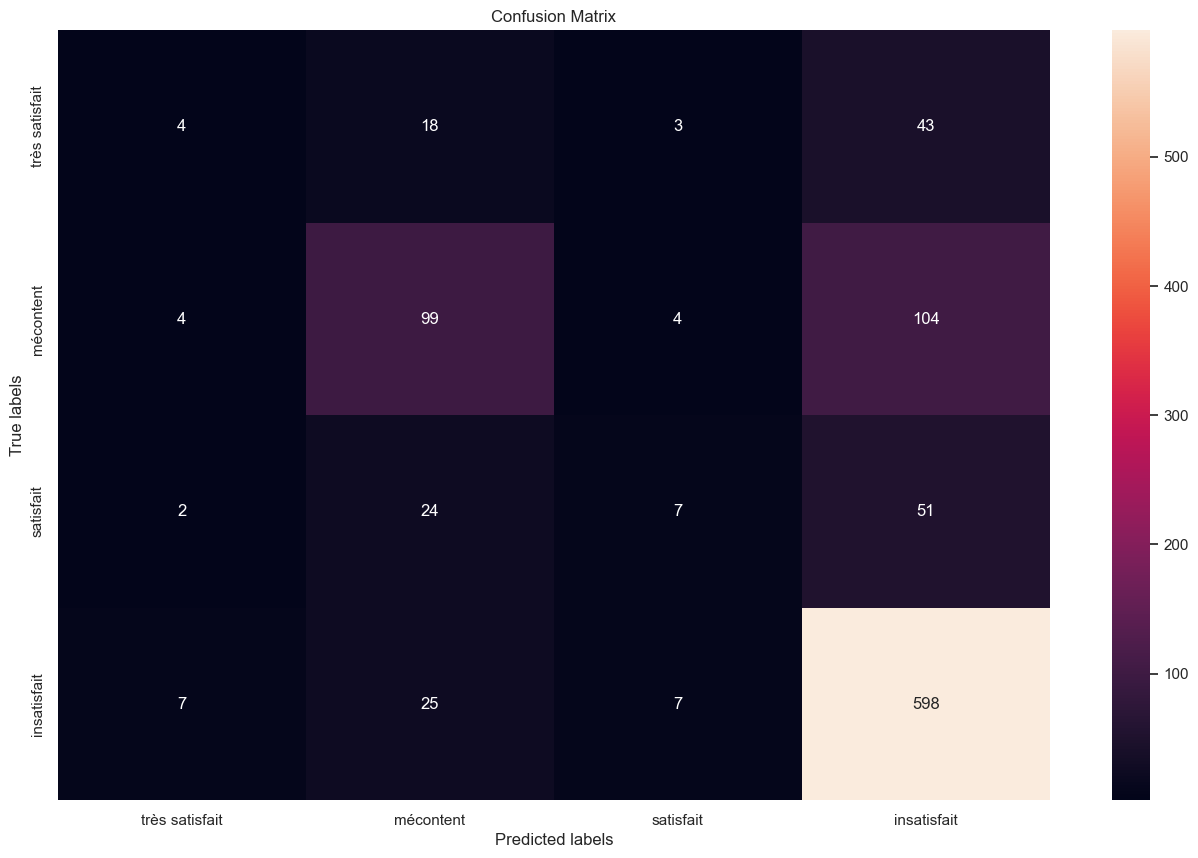

In [62]:

order_class = ["très satisfait","mécontent","satisfait","insatisfait"]

import sklearn.metrics as sklmetrics
from sklearn.metrics import ConfusionMatrixDisplay


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (16,10))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(order_class); ax.yaxis.set_ticklabels(order_class)

La matrice de confusion montre que la classe "insatisfait" est bien prédite avec 598 bonnes prédictions,
mais il existe des confusions significatives pour les autres classes, comme "mécontent" et "très satisfait". Cela
peut indiquer un déséquilibre des données ou des caractéristiques insuffisantes pour séparer correctement
les classes.

## Courbe ROC

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


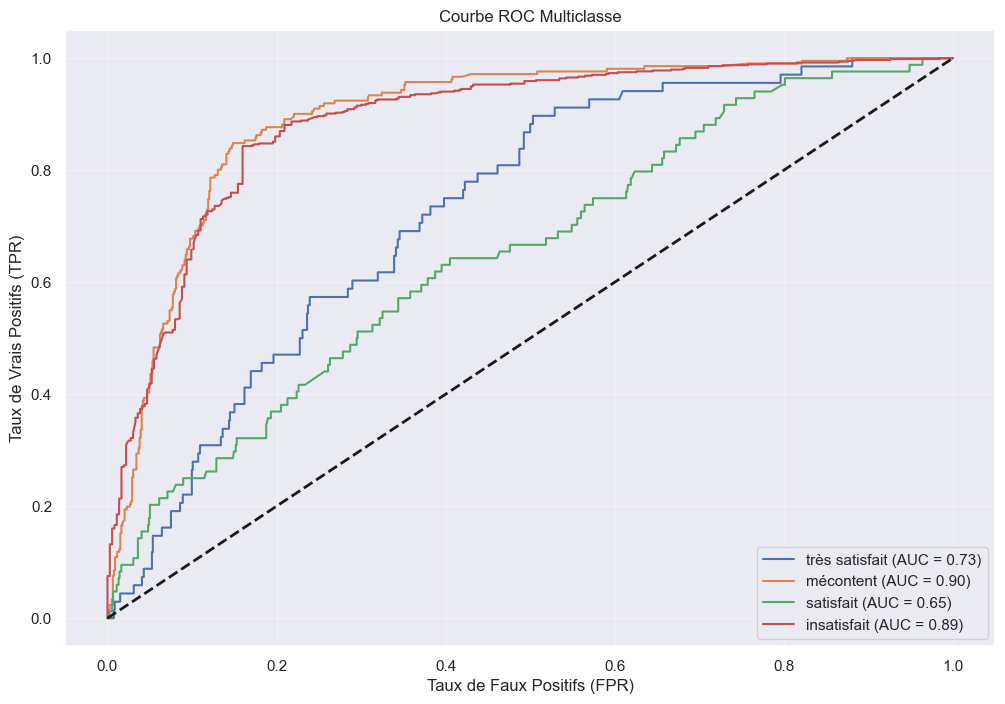

In [63]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3]) 
y_pred_prob = network.predict(x_test) 

plt.figure(figsize=(12, 8))

for i, label in enumerate(order_class):  
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title('Courbe ROC Multiclasse')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


La courbe ROC multiclasse montre les performances du modèle pour chaque catégorie. Les valeurs AUC
indiquent que le modèle est performant pour les classes "mécontent" (AUC = 0,90) et "insatisfait" (AUC =
0,89), tandis que les classes "très satisfait" (AUC = 0,73) et surtout "satisfait" (AUC = 0,66) sont moins
bien discriminées. Cela suggère que le modèle distingue bien certaines classes, mais a plus de mal avec celles
qui sont proches ou sous-représentées. Globalement, les performances sont correctes, mais il reste une marge
d’amélioration pour les classes avec une faible AUC.

# Approche de type « tf-idf »

## Réprésentation graphique

C:\Users\ROMUALD DJAHOUA\AppData\Local\Temp\ipykernel_27960\1669159872.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['joined_tokens'] = sampled_data['tokenized_review_comment_message'].apply(lambda x: ' '.join(x))


Dimensions dataset avant réduction PCA :  (5000, 5317)
Dimensions dataset après réduction PCA :  (5000, 1800)


c:\Users\ROMUALD DJAHOUA\OneDrive\Bureau\Projet - Dat Minig\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.055 
Time : 33.0


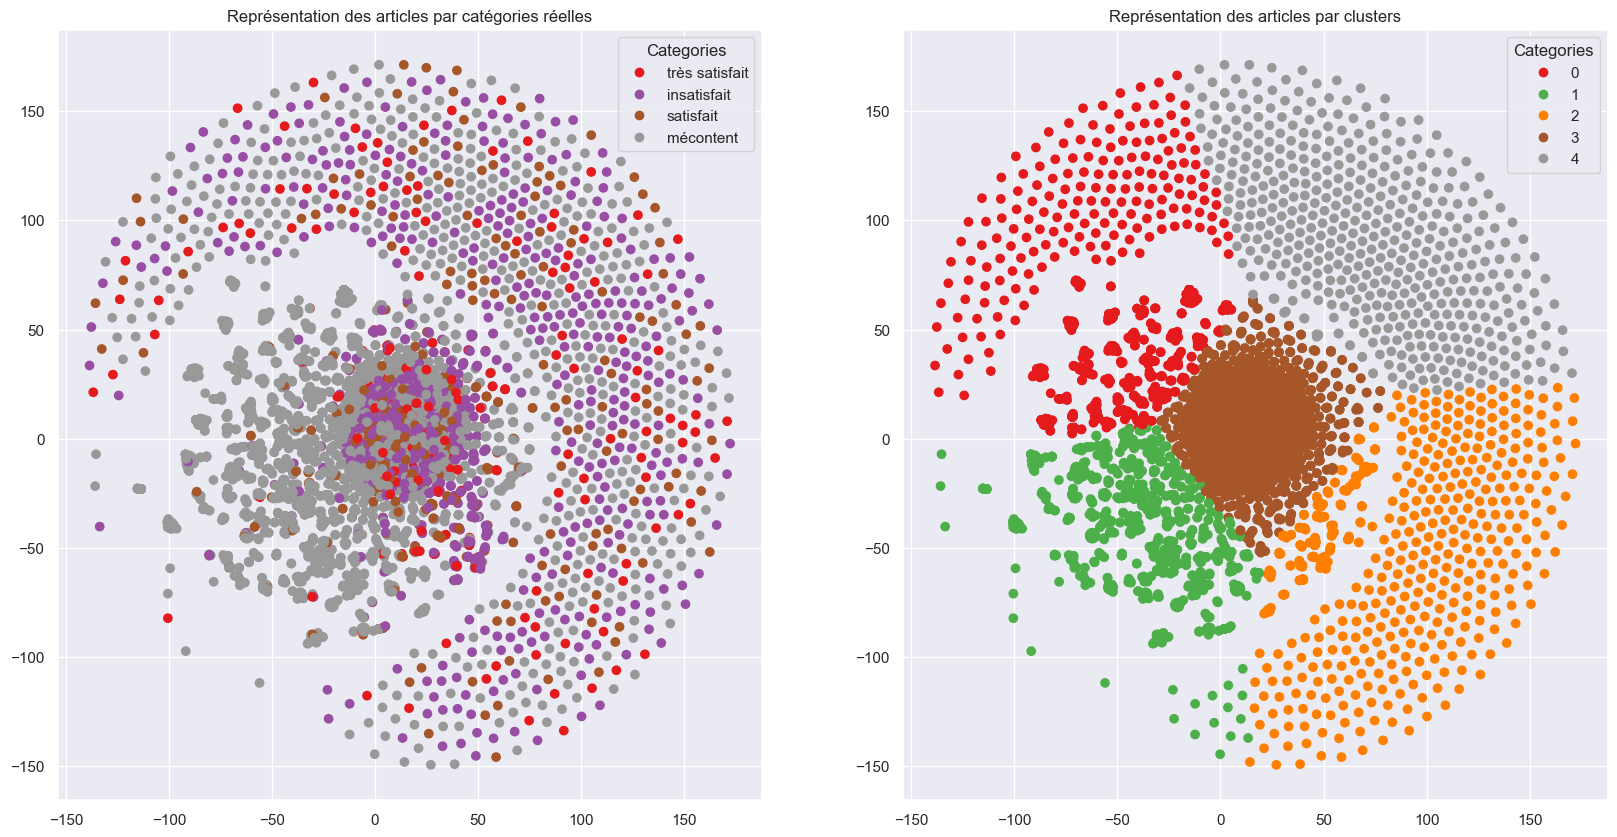

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer



sampled_data = data.iloc[:5000]


sampled_data['joined_tokens'] = sampled_data['tokenized_review_comment_message'].apply(lambda x: ' '.join(x))


cv = TfidfVectorizer()



X = cv.fit_transform(sampled_data["joined_tokens"])

X_pca = TSVD_fct(X)

ARI, X_tsne, model_labels = ARI_fct(X_pca,
                                    sampled_data["target"],
                                    perplexity=10,
                                    learning_rate=50)
TSNE_visu_fct(X_tsne, sampled_data["target"], model_labels)


Les deux graphiques comparent la répartition des catégories réelles (à gauche) et les clusters générés
automatiquement (à droite). À gauche, les points représentant les catégories réelles sont mélangés, montrant
une faible séparation entre elles. À droite, les clusters générés sont nettement mieux définis, avec des regrou-
pements distincts dans l’espace. Cela indique que l’algorithme de clustering a trouvé des structures dans les
données, bien que leur correspondance exacte avec les catégories réelles reste à vérifier. Cette visualisation
met en évidence la capacité des clusters à organiser les données de manière plus structurée

# Modèle de deep learling 

In [65]:
pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV

In [67]:
print("Shape de X_pca :", X_pca.shape)
print("Shape de y :", len(y))

Shape de X_pca : (5000, 1800)
Shape de y : 5000


In [68]:
sample_size = min(len(X_pca), len(y))


X_pca = X_pca[:sample_size]
y = y[:sample_size]


print("Dimensions de X_pca :", X_pca.shape)
print("Dimensions de y :", len(y))


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=25)


print("Taille de x_train :", x_train.shape)
print("Taille de y_train :", len(y_train))
print("Taille de x_test :", x_test.shape)
print("Taille de y_test :", len(y_test))


Dimensions de X_pca : (5000, 1800)
Dimensions de y : 5000
Taille de x_train : (4000, 1800)
Taille de y_train : 4000
Taille de x_test : (1000, 1800)
Taille de y_test : 1000


In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


LE = LabelEncoder()
y = LE.fit_transform(data['target'])  


sample_size = min(len(X_pca), len(y))  
X_pca = X_pca[:sample_size]
y = y[:sample_size]


print("Dimensions de X_pca :", X_pca.shape)
print("Taille de y :", len(y))


print('Valeurs transformées pour les 5 premières lignes :', y[:5])
print('Valeurs originales pour les 5 premières lignes :', LE.inverse_transform(y[:5]))


x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=25)


print("Dimensions de x_train :", x_train.shape)
print("Dimensions de y_train :", len(y_train))
print("Dimensions de x_test :", x_test.shape)
print("Dimensions de y_test :", len(y_test))


Dimensions de X_pca : (5000, 1800)
Taille de y : 5000
Valeurs transformées pour les 5 premières lignes : [3 3 3 3 3]
Valeurs originales pour les 5 premières lignes : ['très satisfait' 'très satisfait' 'très satisfait' 'très satisfait'
 'très satisfait']
Dimensions de x_train : (4000, 1800)
Dimensions de y_train : 4000
Dimensions de x_test : (1000, 1800)
Dimensions de y_test : 1000


In [70]:
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(480,)))
network.add(layers.Dense(4, activation='softmax'))

network.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

from keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

c:\Users\ROMUALD DJAHOUA\OneDrive\Bureau\Projet - Dat Minig\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Matrice de confusion

In [71]:
from keras import models, layers
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train) 
x_test_scaled = scaler.transform(x_test)        


train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)


print("Dimensions de x_train_scaled :", x_train_scaled.shape)
print("Dimensions de train_labels :", train_labels.shape)
print("Dimensions de x_test_scaled :", x_test_scaled.shape)
print("Dimensions de test_labels :", test_labels.shape)


network = models.Sequential()


network.add(layers.Dense(512, activation='relu', input_shape=(x_train_scaled.shape[1],)))
network.add(layers.Dense(train_labels.shape[1], activation='softmax'))  


network.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])


history = network.fit(x_train_scaled, train_labels, 
                      epochs=10, 
                      batch_size=100, 
                      validation_data=(x_test_scaled, test_labels))


test_loss, test_acc = network.evaluate(x_test_scaled, test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


y_pred = network.predict(x_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)  
y_test_class = np.argmax(test_labels, axis=1)  

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_class, y_pred_class)
print("Matrice de confusion :\n", cm)


Dimensions de x_train_scaled : (4000, 1800)
Dimensions de train_labels : (4000, 4)
Dimensions de x_test_scaled : (1000, 1800)
Dimensions de test_labels : (1000, 4)
Epoch 1/10


c:\Users\ROMUALD DJAHOUA\OneDrive\Bureau\Projet - Dat Minig\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5701 - loss: 1.3264 - val_accuracy: 0.6950 - val_loss: 1.0971
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9558 - loss: 0.1691 - val_accuracy: 0.6900 - val_loss: 1.1623
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9621 - loss: 0.1361 - val_accuracy: 0.7020 - val_loss: 1.3279
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9716 - loss: 0.1093 - val_accuracy: 0.6910 - val_loss: 1.4467
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9734 - loss: 0.1025 - val_accuracy: 0.6950 - val_loss: 1.5393
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9771 - loss: 0.0958 - val_accuracy: 0.6880 - val_loss: 1.5616
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9742 - loss: 0.0844 - val_accuracy: 0.6840 - val_loss: 1.6360
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9784 - loss: 0.0716 - val_accuracy: 0.6820 - val_loss: 1.77

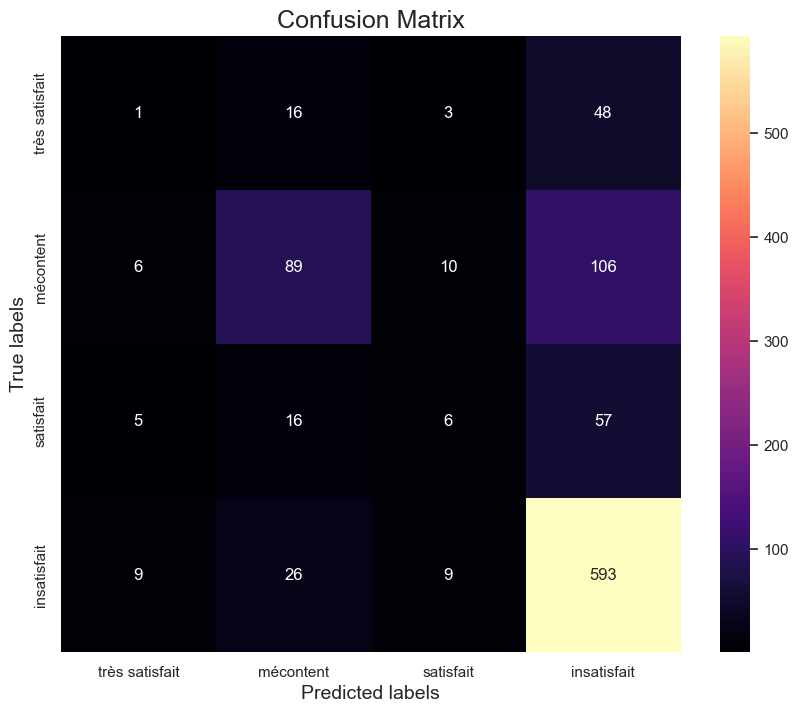

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_class, y_pred_class)


class_labels = ['très satisfait', 'mécontent', 'satisfait', 'insatisfait']


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=class_labels, yticklabels=class_labels)


plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted labels", fontsize=14)
plt.ylabel("True labels", fontsize=14)


plt.show()


La matrice de confusion montre que les prédictions pour la classe "insatisfait" sont les plus précises avec
593 bonnes prédictions. Cependant, les classes "très satisfait", "mécontent" et "satisfait" ont des confusions
significatives, notamment avec la classe "insatisfait". Cela peut indiquer un déséquilibre dans les données ou
des caractéristiques insuffisantes pour discriminer certaines classes. Des approches comme la rééchantillon-
nage des données ou l’utilisation de modèles plus complexes pourraient améliorer les résultats.

## Courbe Roc

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


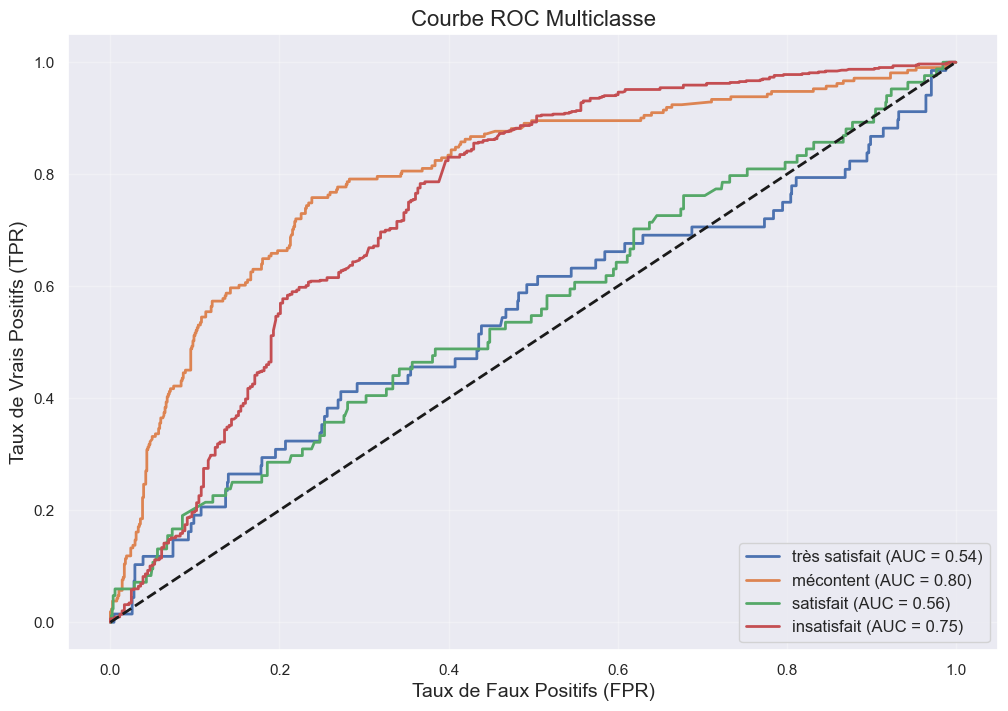

In [73]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  
y_pred_prob = network.predict(x_test_scaled)  


class_labels = ['très satisfait', 'mécontent', 'satisfait', 'insatisfait']


plt.figure(figsize=(12, 8))

for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)


plt.title('Courbe ROC Multiclasse', fontsize=16)
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=14)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


La courbe ROC multiclasse montre que les performances du modèle varient selon les classes. Les classes
"mécontent" (AUC = 0,79) et "insatisfait" (AUC = 0,76) ont les meilleures performances, indiquant une
bonne capacité à les distinguer. En revanche, les classes "très satisfait" (AUC = 0,55) et "satisfait" (AUC
= 0,56) ont des AUC proches du seuil de 0,5, reflétant une difficulté significative à les différencier. Cela
suggère que le modèle a des lacunes pour prédire correctement ces deux classes, probablement en raison de
leur faible représentation ou de similitudes avec d’autres catégories

# **Conclusion**

Le modèle utilisant TF-IDF est préférable, car il exploite mieux les poids des termes pour différencier
les classes, particulièrement dans un contexte où les classes sont déséquilibrées ou partagent des similarités
textuelles.